# Modeling second part

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import itertools

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [64]:
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [2]:
ecfp6 = pd.read_csv('CZP_ecfp6.csv') # Dataset con Morgan fingerprints radio 3

In [3]:
ecfp6.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,7.30103,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,5.00000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,5.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,6.00000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,5.00000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = ecfp6.drop(['molecule_chembl_id', 'canonical_smiles', 'pIC50'], axis=1)

In [5]:
df.head()

,bioactivity_class,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,active,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,active,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,active,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,active,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
bio_mapping = {'active': 0, 'inactive': 1}
df.bioactivity_class = df['bioactivity_class'].map(bio_mapping)

In [7]:
df.head()

,bioactivity_class,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print()
print(to_drop)
len(to_drop)


[]


0

In [9]:
X = df.drop('bioactivity_class', axis=1)
y = df.bioactivity_class 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [11]:
X_train.shape

(382, 1024)

In [12]:
X_test.shape

(164, 1024)

In [13]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,0.015707,0.248691,0.044503,0.036649,0.133508,0.094241,0.023560,0.013089,0.031414,0.028796,...,0.041885,0.065445,0.018325,0.143979,0.031414,0.180628,0.013089,0.047120,0.020942,0.018325
std,0.124502,0.432821,0.206479,0.188145,0.340569,0.292547,0.151873,0.113805,0.174662,0.167452,...,0.200589,0.247634,0.134298,0.351529,0.174662,0.385214,0.113805,0.212174,0.143379,0.134298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
df_columns = X.columns.tolist()

In [15]:
# obtain scale object which can be further applied to scale any data to fit the training set
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=df_columns)

In [16]:
# scale descriptors of the test set compounds
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=df_columns)

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [18]:
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [20]:
etc.fit(X_train_scaled, y_train)

ExtraTreesClassifier(random_state=42)

In [21]:
y_test_pred_etc = etc.predict(X_test_scaled)
y_train_pred_etc = etc.predict(X_train_scaled)
print(classification_report(y_test_pred_etc, y_test))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85        98
           1       0.76      0.79      0.78        66

    accuracy                           0.82       164
   macro avg       0.81      0.81      0.81       164
weighted avg       0.82      0.82      0.82       164



In [22]:
params_etc = {
    'n_estimators': [10,50,100,125,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,3,4,5,6,7,10,12,14],
    'max_depth' : [1,6,7,8, 9,10,None],
    'criterion' :['gini', 'entropy']
    }

In [23]:
etc_gsearch = GridSearchCV(etc, params_etc, n_jobs= 2, cv=5, verbose=2, return_train_score=False, scoring ='f1')

In [24]:
etc_gsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 3277 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done 4897 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 5828 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done 6841 tasks      | elapsed: 12.3min
[Parallel(n_jobs=2)]: Done 7934 tasks      | elapsed: 14.3min
[Parallel(n_jobs=2)]: Done 9109 tasks      | elapsed: 16.7min

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 6, 7, 8, 9, 10, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 10, 12, 14],
                         'n_estimators': [10, 50, 100, 125, 150]},
             scoring='f1', verbose=2)

In [25]:
etc_gsearch.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 125}

In [26]:
y_test_pred_etc_gsearch = etc_gsearch.predict(X_test_scaled)
y_train_pred_etc_gsearch = etc_gsearch.predict(X_train_scaled)
print(classification_report(y_test_pred_etc_gsearch, y_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86        93
           1       0.82      0.79      0.81        71

    accuracy                           0.84       164
   macro avg       0.83      0.83      0.83       164
weighted avg       0.83      0.84      0.83       164



In [27]:
round(accuracy_score(y_test, y_test_pred_etc_gsearch),2)

0.84

In [28]:
confusion_matrix(y_test, y_test_pred_etc_gsearch)

array([[81, 15],
       [12, 56]])

### XGBoost

In [30]:
xgb_clf = xgb.XGBClassifier(n_estimators=250, objective='binary:logistic', silent=True, nthread=1)

In [31]:
xgb_clf.fit(X_train_scaled, y_train)

[00:10:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
y_test_pred_xgb = xgb_clf.predict(X_test_scaled)
y_train_pred_xgb = xgb_clf.predict(X_train_scaled)
print(classification_report(y_test_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        97
           1       0.78      0.79      0.79        67

    accuracy                           0.82       164
   macro avg       0.82      0.82      0.82       164
weighted avg       0.82      0.82      0.82       164



In [35]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [37]:
csv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, 

In [38]:
csv.best_params_

{'max_depth': 2, 'min_child_weight': 2}

In [39]:
y_test_pred_xgb_csv = csv.predict(X_test_scaled)
y_train_pred_xgb_csv = csv.predict(X_train_scaled)
print(classification_report(y_test_pred_xgb_csv, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        97
           1       0.76      0.78      0.77        67

    accuracy                           0.81       164
   macro avg       0.80      0.81      0.80       164
weighted avg       0.81      0.81      0.81       164



In [40]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight':2}

In [43]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=2, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, valida

In [44]:
csv.best_params_

{'max_delta_step': 0, 'subsample': 1}

In [45]:
y_test_pred_xgb_csv = csv.predict(X_test_scaled)
y_train_pred_xgb_csv = csv.predict(X_train_scaled)
print(classification_report(y_test_pred_xgb_csv, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        97
           1       0.76      0.78      0.77        67

    accuracy                           0.81       164
   macro avg       0.80      0.81      0.80       164
weighted avg       0.81      0.81      0.81       164



In [46]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 1

In [50]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [51]:
csv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=2, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method=None, validate_par

In [52]:
csv.best_params_

{'learning_rate': 0.2}

In [67]:
y_test_pred_xgb_csv2 = csv.predict(X_test_scaled)
y_train_pred_xgb_csv2 = csv.predict(X_train_scaled)
print(classification_report(y_test_pred_xgb_csv2, y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        97
           1       0.76      0.78      0.77        67

    accuracy                           0.81       164
   macro avg       0.80      0.81      0.80       164
weighted avg       0.81      0.81      0.81       164



In [53]:
fix_params['learning_rate'] = 0.2
params_final =  fix_params
print(params_final)

{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight': 2, 'max_delta_step': 0, 'subsample': 1}


In [54]:
xgdmat_train = xgb.DMatrix(X_train_scaled, y_train)
xgdmat_test = xgb.DMatrix(X_test_scaled, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)


[12:30:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




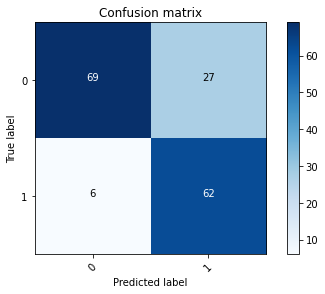

Precision =     0.697
Recall (TPR) =  0.912
Fallout (FPR) = 2.812e-01


In [71]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.3
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1)

In [ ]:
xgb_clf_final = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic')

In [66]:
y_test_pred_xgb_fin = xgb_final.predict(X_test_scaled)
y_train_pred_xgb_fin = xgb_final.predict(X_train_scaled)
print(classification_report(y_test_pred_xgb_fin, y_test))

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)